In [ ]:
import argparse
import torch
from transformers import AutoTokenizer, LlamaForCausalLM, AutoModelForCausalLM, LlamaTokenizer
import sys
from statistics import mean
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
import re
from matplotlib import pyplot as plt
import torch.nn.functional as F

import pandas as pd

#keep track of current decoder layer
lid = 0
DATA_PATH = "/shared/vsathia2/sp_mlp_predictor/vanilla_llama/"
#keep track of start points(upto 50 layers)
fstarts = [0]*50
fmlp_ptrs = []
factv_ptrs = []
all_outputs = []
def actv_hook(module, inputs, outputs):
    # Need to save output of activation function
    global lid,fmlp_ptrs,factv_ptrs,fstarts,all_outputs
    all_outputs.append(outputs)
    #save this output for analysis later
    return outputs

def mlp_hook(module, inputs, outputs):
    # Need to save input of MLP
    global lid,fmlp_ptrs,factv_ptrs,fstarts
    
    lid+=1

    return outputs

def wikitext_detokenize(string):
    # contractions
    string = string.replace("s '", "s'")
    string = re.sub(r"/' [0-9]/", r"/'[0-9]/", string)
    # number separators
    string = string.replace(" @-@ ", "-")
    string = string.replace(" @,@ ", ",")
    string = string.replace(" @.@ ", ".")
    # punctuation
    string = string.replace(" : ", ": ")
    string = string.replace(" ; ", "; ")
    string = string.replace(" . ", ". ")
    string = string.replace(" ! ", "! ")
    string = string.replace(" ? ", "? ")
    string = string.replace(" , ", ", ")
    # double brackets
    string = re.sub(r"\(\s*([^\)]*?)\s*\)", r"(\1)", string)
    string = re.sub(r"\[\s*([^\]]*?)\s*\]", r"[\1]", string)
    string = re.sub(r"{\s*([^}]*?)\s*}", r"{\1}", string)
    string = re.sub(r"\"\s*([^\"]*?)\s*\"", r'"\1"', string)
    string = re.sub(r"'\s*([^']*?)\s*'", r"'\1'", string)
    # miscellaneous
    string = string.replace("= = = =", "====")
    string = string.replace("= = =", "===")
    string = string.replace("= =", "==")
    string = string.replace(" " + chr(176) + " ", chr(176))
    string = string.replace(" \n", "\n")
    string = string.replace("\n ", "\n")
    string = string.replace(" N ", " 1 ")
    string = string.replace(" 's", "'s")

    return string

def prepare_data(dpath="wikitext",dname="wikitext-2-raw-v1",split="test",text_column="text"):

    data_split = load_dataset(dpath, dname, split=split)
    text_list = "\n\n".join([wikitext_detokenize(t) for t in data_split[text_column]])
    return text_list

def evaluate(model,tokenizer,device="cuda:0",dataset_path="wikitext",dataset_name="wikitext-2-raw-v1",split="test",text_column="text",n_ctx=16384,seq_len=2048):

    # prepare data
    _text = prepare_data(dataset_path,dataset_name,split,text_column)
    tokens = tokenizer(_text, truncation=False, return_tensors="pt").input_ids.to(device)

    # process tokens to include batch size = (n_ctx / seq_len)

    cutoff = 393216

    # with tqdm(range(len(tokens[0]) // n_ctx), desc="Inference data collection: - ") as progress:
    for i in tqdm(range(0,min(cutoff,len(tokens[0])),n_ctx),desc="Inference loop"):
        # Process tokens in batched manner

        start = i
        end = start + n_ctx

        # vectorize inner loop
        tokens_batch = tokens[:,start:end].view(-1,seq_len)
        

        token_org = tokens_batch[0,0].item()
        tokens_batch[0,0] = tokenizer.bos_token_id

        global lid
        lid = 0

        with torch.no_grad():
            print(tokens_batch.shape)
            model.cuda()
            tokens_batch.cuda()
            outputs = model(tokens_batch)
        # print(f"output logit shape: {outputs.logits.shape}")

        tokens_batch[0,0] = token_org
        break

def generate_label(y):
    onehot = (y>0).to(y.dtype)
    return onehot

def main(args):
    # print(args)
    global DATA_PATH
    DATA_PATH = args.data_path
    # Init the tokenizer
    tokenizer=AutoTokenizer.from_pretrained(args.model_path,padding_side='left')
    tokenizer.eos_token=tokenizer.pad_token

    # Init the model itself
    # Use eager attention instead of flash/SDPA
    m = AutoModelForCausalLM.from_pretrained(args.model_path, device_map=args.device, attn_implementation="eager")

    # print(m)
    #register hooks on model
    # print(len(m.model.layers))
    # exit()
    n_layers = len(m.model.layers)

    #initialize file pointers
    global fmlp_ptrs, factv_ptrs
    # fmlp_ptrs = []
    # for i in range(n_layers):
    #     fmlp_ptrs.append(np.memmap(f"{DATA_PATH}/mlp_sp_x_{i}.mmap",dtype="float16",mode="w+",shape=(393216,m.config.hidden_size)))
    #     factv_ptrs.append(np.memmap(f"{DATA_PATH}/mlp_label_{i}.mmap",dtype="float16",mode="w+",shape=(393216,m.config.intermediate_size)))

    with torch.no_grad():

        mlp_funcs = []
        mlp_handles = []
        actv_funcs = []
        actv_handles = []
        for i in range(n_layers):
            mlp_funcs.append(m.model.layers[i].mlp)
            actv_funcs.append(m.model.layers[i].mlp.act_fn)
            mlp_handles.append(mlp_funcs[-1].register_forward_hook(mlp_hook))
            actv_handles.append(actv_funcs[-1].register_forward_hook(actv_hook))
        # mlp_func0 = m.model.layers[0].mlp
        # mlp_handle0 = mlp_func0.register_forward_hook(mlp_hook)
        #
        # mlp_func1 = m.model.layers[1].mlp
        # mlp_handle1 = mlp_func1.register_forward_hook(mlp_hook)

        #begin data collection
        evaluate(m,tokenizer)

        # #flush changes to disk
        # for i in range(n_layers):
        #     fmlp_ptrs[i].flush()
        #     factv_ptrs[i].flush()
        #free all hooks
        for i in range(n_layers):
            mlp_handles[i].remove()
            actv_handles[i].remove()
        # mlp_handle0.remove()
        # mlp_handle1.remove()

        #analyse all_outputs[32]

        #Compute sparsity per layer, save it to disk
        layer_sparsity = [0]*50
        for i in range(n_layers):
            curr_out = all_outputs[i]
            y = generate_label(curr_out)
            # sparsity = y.sum()
            
            layer_sparsity[i] += (1.0 - (torch.count_nonzero(curr_out)/torch.numel(curr_out)))*100.0
            #layer_sparsity[i] += y.sum(dim=-1).float().mean().item()
            print(f"layer_sparsity : {(layer_sparsity[i].item())}%")

        layer_sparsity = torch.tensor(layer_sparsity, device = 'cpu')
        # = layer_sparsity.data.numpy()
        #Compute cosine similarity between layers
        plt.plot(np.arange(n_layers), layer_sparsity[:n_layers], label =  'ReLU Llama2 7B')
        plt.xlabel('Transformer layer')
        plt.ylabel('% Sparsity')
        plt.legend()
        plt.show()
        d = {"sparsity": layer_sparsity[:n_layers], "1":np.zeros(n_layers),"2":np.zeros(n_layers),"4":np.zeros(n_layers),"8":np.zeros(n_layers)}
        df = pd.DataFrame(data=d)
        for nsep in [1,2,4,8]:
            #Compute cosine similarity
            for i in range(n_layers):
                vec1 = all_outputs[i]
                if (i+nsep) < n_layers:
                    vec2 = all_outputs[i+nsep]
                else:
                    vec2 = all_outputs[i-nsep]
                out=F.cosine_similarity(vec1,vec2,dim=-1)
                out=out.mean().item()
                df.at[i,str(nsep)] = out
                print(f"Cosine similarity b/w {i} and {i+nsep} : {out}")
                # import torch.nn as nn
        plt.plot(np.arange(n_layers-1), df['1'][:n_layers-1], label =  'n=1')
        plt.plot(np.arange(n_layers-2), df['2'][:n_layers-2], label =  'n=2')
        plt.plot(np.arange(n_layers-4), df['4'][:n_layers-4], label =  'n=4')
        plt.plot(np.arange(n_layers-8), df['8'][:n_layers-8], label =  'n=8')
        plt.xlabel('Transformer layer')
        plt.ylabel('Cosine Similarity')
        plt.legend()
        plt.show()
        df.to_csv(f"{args.model_path}/sparse_stats.csv")


"""args = {}
args["dataset"] = "wikitext"
args["model_path"] = "/shared/vsathia2/hf_models/vanilla_llama/"
args["data_path"] = "/shared/vsathia2/sp_mlp_predictor/vanilla_llama"
args["device"] = "gpu"
main(args)
"""


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='GCN')
    parser.add_argument("--dataset", type=str, default="wikitext",help="Dataset name")
    parser.add_argument("--model-path",type=str,default="/shared/vsathia2/hf_models/relu-llama/")
    parser.add_argument("--data-path",type=str,default="/shared/vsathia2/sp_mlp_predictor/relu-llama")

    parser.add_argument("--device", type=str, default="cpu",
                        help="Select device to perform computations on")

    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    main(args)




In [1]:
import torch
import pickle
from main_mlp import *
import torch.nn as nn
from matplotlib import pyplot as plt
plt.style.use("bmh")


def get_list(model_name, ext):
    target_list = []
    filename = f"/shared/vsathia2/inference_outputs/{model_name}_{ext}"
    with open(filename, "rb") as fp:
        target_list = pickle.load(fp)
    return target_list

def generate_label(y, thresh=0):
    # positive
    one_hot = (y > thresh).to(y.dtype)
    return one_hot


In [2]:
def visualize_all(values, model_names, title = "", filename = "sparsity.png", ylabel = 'Sparsity (%)', xlabel = 'Transformer layer'):
    for i, model_name in enumerate(model_names):
        n_layers = len(values[i])
        plt.plot(np.arange(n_layers), values[i], label =  model_name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.savefig(filename)

In [3]:
def evaluate_sparsity(model_name, all_outputs):
    layer_sparsity = [0]*50

    n_layers = len(all_outputs)
    for i in range(n_layers):
        curr_out = all_outputs[i]
        y = generate_label(curr_out)
        # sparsity = y.sum()
        
        layer_sparsity[i] += (1.0 - (torch.count_nonzero(curr_out)/torch.numel(curr_out)))*100.0
        #layer_sparsity[i] += y.sum(dim=-1).float().mean().item()
        print(f"layer_sparsity : {(layer_sparsity[i].item())}%")
    
    layer_sparsity = torch.tensor(layer_sparsity, device = 'cpu')
    return layer_sparsity[:n_layers]
    

layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_sparsity : 71.39714050292969%
layer_sparsity : 70.43721771240234%
layer_sparsity : 68.07931518554688%
layer_sparsity : 68.81309509277344%
layer_sparsity : 67.7017822265625%
layer_sparsity : 67.40618133544922%
layer_sparsity : 67.91454315185547%
layer_sparsity : 67.3946533203125%
layer_sparsity : 69.37055969238281%
layer_sparsity : 70.23057556152344%
layer_sparsity : 69.78174591064453%
layer_sparsity : 67.42063903808594%
layer_sparsity : 67.79874420166016%
layer_sparsity : 66.80530548095703%
layer_sparsity : 66.02950286865234%
layer_sparsity : 64.96153259277344%
layer_sparsity : 64.33921813964844%
layer_sparsity : 64.25597381591797%
layer_sparsity : 64.29228973388672%
layer_sparsity : 64.767593383789

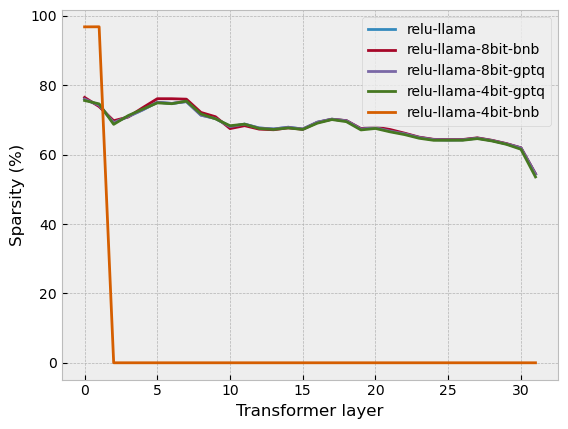

In [10]:
model_names = ["relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "relu llamasparsity with 4bnb.png")

layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_sparsity : 71.39714050292969%
layer_sparsity : 70.43721771240234%
layer_sparsity : 68.07931518554688%
layer_sparsity : 68.81309509277344%
layer_sparsity : 67.7017822265625%
layer_sparsity : 67.40618133544922%
layer_sparsity : 67.91454315185547%
layer_sparsity : 67.3946533203125%
layer_sparsity : 69.37055969238281%
layer_sparsity : 70.23057556152344%
layer_sparsity : 69.78174591064453%
layer_sparsity : 67.42063903808594%
layer_sparsity : 67.79874420166016%
layer_sparsity : 66.80530548095703%
layer_sparsity : 66.02950286865234%
layer_sparsity : 64.96153259277344%
layer_sparsity : 64.33921813964844%
layer_sparsity : 64.25597381591797%
layer_sparsity : 64.29228973388672%
layer_sparsity : 64.767593383789

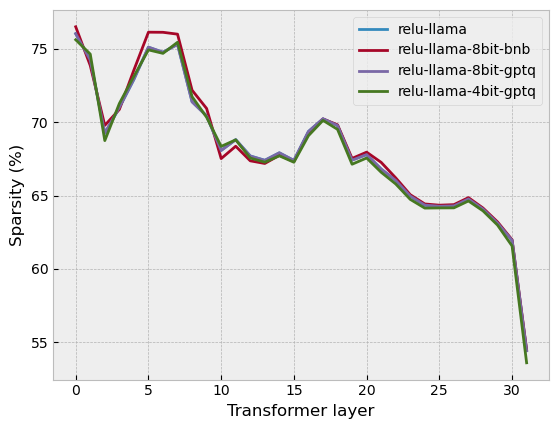

In [7]:
model_names = ["relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq"]#, "relu-llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "sparsity wo 4bnb.png")

layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0025391578674316406%
layer_sparsity : 0.0012218952178955078%
layer_sparsity : 0.0006020069122314453%
layer_sparsity : 0.0008225440979003906%
layer_sparsity : 0.00019669532775878906%
layer_sparsity : 0.0008165836334228516%
layer_sparsity : 0.0008881092071533203%
layer_sparsity 

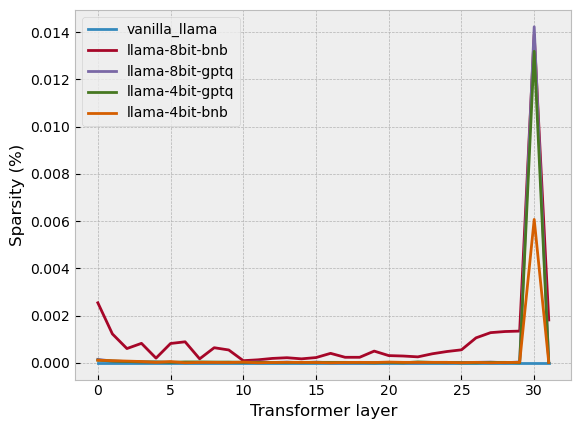

In [9]:
model_names = ["vanilla_llama", "llama-8bit-bnb", "llama-8bit-gptq",  "llama-4bit-gptq", "llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "vanilla_llama_variations.png")

In [ ]:
layer_sparsity = [0]*50

n_layers = len(all_outputs)
for i in range(n_layers):
    curr_out = all_outputs[i]
    y = generate_label(curr_out)
    # sparsity = y.sum()
    
    layer_sparsity[i] += (1.0 - (torch.count_nonzero(curr_out)/torch.numel(curr_out)))*100.0
    #layer_sparsity[i] += y.sum(dim=-1).float().mean().item()
    print(f"layer_sparsity : {(layer_sparsity[i].item())}%")

layer_sparsity = torch.tensor(layer_sparsity, device = 'cpu')
# = layer_sparsity.data.numpy()
#Compute cosine similarity between layers
plt.plot(np.arange(n_layers), layer_sparsity[:n_layers], label =  'ReLU Llama2 7B')
plt.xlabel('Transformer layer')
plt.ylabel('% Sparsity')
plt.legend()
plt.show()


